## **1. Mount google drive**
---

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **2. Import the libraries**
---

In [2]:
import sys
import os
import matplotlib
import librosa
import timeit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import zipfile
import sklearn.metrics as metrics

from IPython.display import clear_output
from scipy.io import wavfile
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

print("Versions of key libraries")
print("---")
print("tensorflow:", tf.__version__)
print("numpy:     ", np.__version__)
print("matplotlib:", matplotlib.__version__)
print("pandas    :", pd.__version__)
print("librosa   :", librosa.__version__)


Versions of key libraries
---
tensorflow: 2.3.0
numpy:      1.18.5
matplotlib: 3.2.2
pandas    : 1.0.5
librosa   : 0.6.3


## **3. Copy data.zip from google drive to local directory**
---

In [3]:
print("Copy speechsub.zip from google drive to local directory ...")
zipSrc  = zipfile.ZipFile("/content/gdrive/My Drive/iss/rtavs/data/speechsub.zip", 'r')

print("Unzip speechsub.zip ...")
zipSrc.extractall("/content")

zipSrc.close()
print("Unzip completes.")

Copy speechsub.zip from google drive to local directory ...
Unzip speechsub.zip ...
Unzip completes.


## **4. Change working directory to /content/**
---

In [4]:
os.chdir('/content/')
print("Current working directory:")
os.getcwd()

Current working directory:


'/content'

## **5. Setup matplotlib**
---

In [5]:
plt.style.use('seaborn')                   # if want to use the default style, set 'classic'
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= True
plt.rcParams['ytick.left']      = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['figure.figsize']  = [7,7]   # Set the figure size to be 7 inch for (width,height)

print("Matplotlib setup completes.")

Matplotlib setup completes.


## **6. Take a look at a soundwave "go"**
---
* Step 1: Build the path to the file
* Step 2: Use `librosa` to load the wave file
* Step 3: Produce the plot

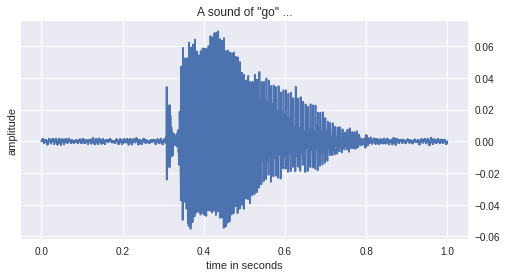

In [6]:
                                                                                # Step 1
audioPth    = 'speechsub'
goSample    = os.path.join(audioPth,
                           'go',
                           '00f0204f_nohash_1.wav')

(smp,smpR)  = librosa.load(goSample,sr=16000)                                   # Step 2

                                                                                # Step 3
plt.figure(figsize=(8,4))
plt.plot(np.linspace(0,               # Start
                     len(smp)/smpR,   # Stop (convert sample number into second)
                     len(smp)),       # Number of points
         smp)
plt.title('A sound of "go" ...')
plt.xlabel('time in seconds')
plt.ylabel('amplitude')
plt.show()

## **7. Check the number of records in each category**
---
* Step 1: Setup a label list
* Step 2: Create `numOfRecords` to hold the wavefiles by label, and create `totalRecords` to store the total amount of records in our dataset
* Step 3: Get all the wave files under each label/directory
* Step 4: Get the total number of waves under each label/directory
* Step 5: Add the number to the total
* Step 6: Plot a horizontal bar chart

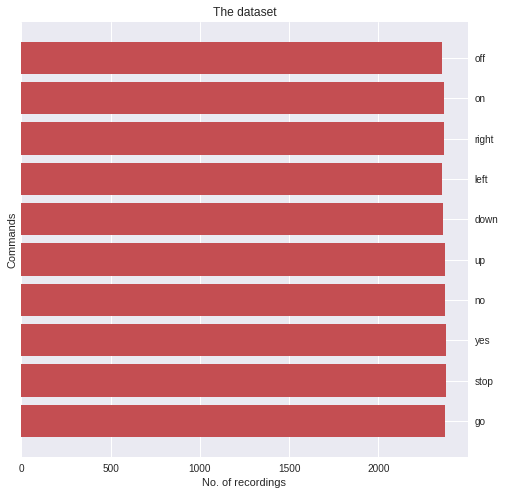

In [7]:
                                                                                # Step 1
labels      = ["go",
               "stop",
               "yes", 
               "no", 
               "up", 
               "down", 
               "left", 
               "right", 
               "on", 
               "off"]

                                                                                # Step 2                                     
numOfRecords= []
totalRecords= 0

for lbl in labels:
                                                                                # Step 3
    pth     = os.path.join(audioPth,lbl)
    records = [f for f in os.listdir(pth) if f.endswith('.wav')]
    
    numOfRecords.append(len(records))                                           # Step 4
    totalRecords    = totalRecords+len(records)                                 # Step 5

                                                                                # Step 6
plt.figure(figsize=(8,8))
plt.barh(np.arange(len(labels)), 
         numOfRecords,
         color="C2")
plt.xlabel('No. of recordings')
plt.ylabel('Commands')
plt.yticks(np.arange(len(labels)), labels)
plt.title('The dataset')
plt.show()

## **8. Check the distribution of durations in the dataset**
---
* Step 1: Create an empty list `durations` to hold all the durations of each wave file
* Step 2: Get all the wave files under each label/directory
* Step 3: For each wave file, load the wavefile, determine the duration of each wave file and append the value to `durations`
* Step 4: Plot a histogram

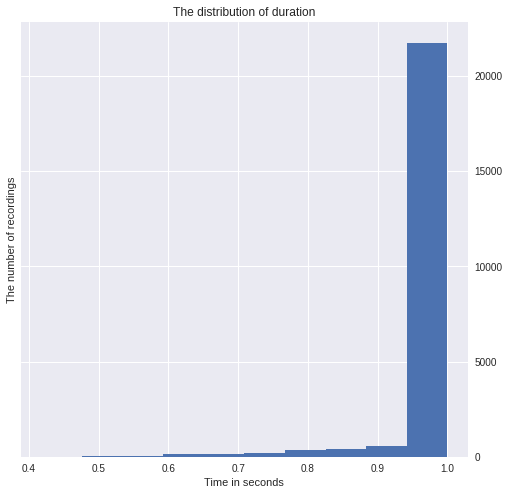

In [8]:
durations   = []                                                                # Step 1

for lbl in labels:
                                                                                # Step 2
    pth     = os.path.join(audioPth,lbl)
    records = [f for f in os.listdir(pth) if f.endswith('.wav')]
    
    for rcd in records:
                                                                                # Step 3
        (smpR,smp)  = wavfile.read(os.path.join(pth,rcd))        
        durations.append(float(len(smp)/smpR))      

                                                                                # Step 4
plt.figure(figsize=(8,8))
plt.title('The distribution of duration')
plt.ylabel('The number of recordings')
plt.xlabel('Time in seconds')
durationHist    = plt.hist(durations)

## **9. Prepare the dataset**
---
* Step 1: Create empty list `allRecords` and `allLabels` to hold all the wavefiles and labels
* Step 2: Setup resampling rate and input length. 
* Step 3: Create a timestamp and a running number `run`
* Step 4: Get all the wavefiles (the path) under each label/directory
* Step 5: For each wavefile, use `librosa` to load the file and perform resampling
* Step 6: If the length of the resultant array is equal to the input length, append the array to `allRecords` and append the label to `allLabels`
* Step 7: Report the reading progress
* Step 8: Convert `allRecords` into numpy array. Report the shape and data type.
* Step 9: Save `allRecords` and `allLabels` into npy file for future easier usage.

In [9]:
                                                                                # Step 1
allRecords  = []
allLabels   = []

                                                                                # Step 2
resmpRate   = 8000
inputLength = 8000

                                                                                # Step 3
start       = timeit.default_timer()
run         = 1

for lbl in labels:
                                                                                # Step 4
    pth     = os.path.join(audioPth,lbl)
    records = [f for f in os.listdir(pth) if f.endswith('.wav')]

    for rcd in records:
                                                                                # Step 5
        (smp,smpR)  = librosa.load(os.path.join(pth,rcd),sr=16000)
        smp         = librosa.resample(smp,
                                       smpR, 
                                       resmpRate)
        
                                                                                # Step 6
        if (len(smp)==inputLength): 
            allRecords.append(smp)
            allLabels.append(lbl)
        
                                                                                # Step 7
        clear_output(wait=True)
        stop    = timeit.default_timer()

        if (run/totalRecords) < 0.05:
            timeExpected  = "Calculating ..."
        else:
            timeNow       = timeit.default_timer()
            timeExpected  = np.round((timeNow-start)/run*totalRecords/60,2)

        print("Checking progress:", run ,"records")   
        print("Time taken       : ", np.round((stop-start)/60,2), "minutes")
        print("Expected duration:", timeExpected, "minutes")
        print('')

        run     = run+1
          
                                                                                # Step 8
allRecords  = np.array(allRecords).reshape(-1,inputLength,1)
print("The shape of allRecords is", allRecords.shape, "and the data type is", allRecords.dtype) 

                                                                                # Step 9
np.save("/content/gdrive/My Drive/iss/rtavs/data/allRV1Records.npy",allRecords)
np.save("/content/gdrive/My Drive/iss/rtavs/data/allRV1Labels.npy",allLabels)

Checking progress: 23682 records
Time taken       :  74.55 minutes
Expected duration: 74.55 minutes

The shape of allRecords is (21312, 8000, 1) and the data type is float32


## **10. Prepare the labels**
---
* Step 1: Create label encoder
* Step 2: Generate the labels
* Step 3: Extract the mapping between numbers and labels
* Step 4: Convert each item in `classes` to string
* Step 5: Perform one-hot encoding

In [10]:
le      = LabelEncoder()                                                        # Step 1
lbls    = le.fit_transform(allLabels)                                           # Step 2
classes = list(le.classes_)                                                     # Step 3
classes = [str(c) for c in classes]                                             # Step 4
lbls    = to_categorical(lbls,num_classes=len(classes))                         # Step 5

print(classes)

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']


## **11. Split the dataset into training and testing set**
---

In [11]:
(trDat,
 vlDat,
 trLbl, 
 vlLbl) = train_test_split(allRecords,
                           lbls,
                           stratify=lbls,
                           test_size=0.2,
                           random_state=229,
                           shuffle=True)
 
print("The shape of trDat is", trDat.shape)
print("The shape of vlDat is", vlDat.shape)

The shape of trDat is (17049, 8000, 1)
The shape of vlDat is (4263, 8000, 1)


## **12. Define deep learning model**
---
* Step 1: Set a name for the coming model (required for saving)
* Step 2: Define the convolutional neural network model (to be completed)
* Step 3: Create models for training and testing
* Step 4: Display the summary of the model of interest 

In [12]:
modelname    = 'speechRV1'                                                      # Step 1

                                                                                # Step 2
def createModel(inputSize):
    ipt = Input(shape=(inputSize,1))

    x   = Conv1D(8, 11, padding='valid', activation='relu')(ipt)
    x   = MaxPooling1D(4)(x)
    x   = Dropout(0.25)(x)
    
    x   = Conv1D(16, 11, padding='valid', activation='relu')(x)
    x   = MaxPooling1D(4)(x)
    x   = Dropout(0.25)(x)
    
    x   = Conv1D(32, 11, padding='valid', activation='relu')(x)
    x   = MaxPooling1D(4)(x)
    x   = Dropout(0.25)(x)
    
    x   = Conv1D(64, 11, padding='valid', activation='relu')(x)
    x   = MaxPooling1D(4)(x)
    x   = Dropout(0.25)(x)
    
    x   = Flatten()(x)
    x   = Dense(256, activation='relu')(x)
    x   = Dropout(0.5)(x)
    
    x   = Dense(128, activation='relu')(x)
    x   = Dropout(0.5)(x)
    
    x   = Dense(len(classes), activation='softmax')(x)
    
    model = Model(ipt, x)
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    return model

                                                                                # Step 3
model       = createModel(inputLength) # This is meant for training
modelGo     = createModel(inputLength) # This is used for final testing

model.summary()                                                                 # Step 4


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7990, 8)           96        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1997, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1997, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1987, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 496, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 496, 16)          

## **13. Create callbacks**
---
* Step 1: Create a callback to save the model from an epoch when validation accuracy is the highest
* Step 2: Create a callback to save the training loss, training accuracy, validation loss and validation accuracy of each epoch into a csv file
* Step 3: Put the two callbacks objects into a list

In [13]:
                                                                                # Step 1
folderpath      = '/content/gdrive/My Drive/iss/rtavs/colab/'
filepath        = folderpath + modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_accuracy', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

csv_logger      = CSVLogger(folderpath+modelname +'.csv')                       # Step 2
callbacks_list  = [checkpoint,csv_logger]                                       # Step 3

print("Callbacks created:")
print(callbacks_list[0])
print(callbacks_list[1])
print('')
print("Path to model:", filepath)
print("Path to log:  ", folderpath+modelname+'.csv')

Callbacks created:

Path to model: /content/gdrive/My Drive/iss/rtavs/colab/speechRV1.hdf5
Path to log:   /content/gdrive/My Drive/iss/rtavs/colab/speechRV1.csv


## **14. Train the deep learning model**
---

In [14]:
model.fit(trDat, 
          trLbl, 
          validation_data=(vlDat, vlLbl), 
          epochs=100, 
          batch_size=32,
          shuffle=True,
          callbacks=callbacks_list)

Epoch 1/100
533/533 [==============================] - 93s 175ms/step - loss: 2.2222 - accuracy: 0.1546 - val_loss: 1.9558 - val_accuracy: 0.2580
Epoch 2/100
533/533 [==============================] - 92s 173ms/step - loss: 1.6392 - accuracy: 0.3858 - val_loss: 1.2197 - val_accuracy: 0.5928
Epoch 3/100
533/533 [==============================] - 93s 174ms/step - loss: 1.2016 - accuracy: 0.5596 - val_loss: 0.9998 - val_accuracy: 0.6603
Epoch 4/100
533/533 [==============================] - 92s 173ms/step - loss: 1.0350 - accuracy: 0.6362 - val_loss: 0.9592 - val_accuracy: 0.6636
Epoch 5/100
533/533 [==============================] - 92s 172ms/step - loss: 0.9412 - accuracy: 0.6726 - val_loss: 0.8592 - val_accuracy: 0.6946
Epoch 6/100
533/533 [==============================] - 92s 173ms/step - loss: 0.8783 - accuracy: 0.6995 - val_loss: 0.6697 - val_accuracy: 0.7764
Epoch 7/100
533/533 [==============================] - 98s 184ms/step - loss: 0.8100 - accuracy: 0.7236 - val_loss: 0.7749 -

## **15. Validate the deep learning model**
---
* Step 1: Load the trained weights and compile the model
* Step 2: Make prediction

In [21]:
                                                                                # Step 1
modelGo.load_weights(filepath)
modelGo.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])

predicts    = modelGo.predict(vlDat)                                            # Step 2
print("Prediction completes.")

Prediction completes.


## **16. Report classification metrics**
---
* Step 1: Convert label from one-hot to integer
* Step 2: Calculate the accuracy score
* Step 3: Generate classification report

In [22]:
                                                                                # Step 1
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(vlLbl,axis=1)

testScores  = metrics.accuracy_score(testout,predout)                           # Step 2

                                                                                # Step 3
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,
                                    predout,
                                    target_names=classes,
                                    digits=4))

Best accuracy (on testing dataset): 90.69%
              precision    recall  f1-score   support

        down     0.9361    0.8860    0.9104       430
          go     0.9047    0.9262    0.9153       420
        left     0.9002    0.9169    0.9085       433
          no     0.8958    0.9214    0.9085       420
         off     0.8971    0.8531    0.8746       429
          on     0.9352    0.8907    0.9124       421
       right     0.9638    0.9258    0.9444       431
        stop     0.9281    0.9195    0.9238       435
          up     0.7896    0.9199    0.8498       412
         yes     0.9379    0.9097    0.9236       432

    accuracy                         0.9069      4263
   macro avg     0.9088    0.9069    0.9071      4263
weighted avg     0.9094    0.9069    0.9074      4263



## **17. Print confusion matrix**
---

In [23]:
confusion   = metrics.confusion_matrix(testout,predout)
print(confusion)

[[381  11   0  13   1   4   0  10   5   5]
 [  6 389   0  11   1   2   0   1   9   1]
 [  0   0 397   7   2   1   6   2   3  15]
 [  7   9   3 387   0   2   2   2   5   3]
 [  3   3   4   1 366  11   2   5  34   0]
 [  4   4   0   0  18 375   3   2  15   0]
 [  0   1  13   4   1   3 399   2   7   1]
 [  4   5   1   0   5   1   1 400  18   0]
 [  0   4   4   3  14   2   0   5 379   1]
 [  2   4  19   6   0   0   1   2   5 393]]


## **18. Plot curves on validation loss and accuracy**
---

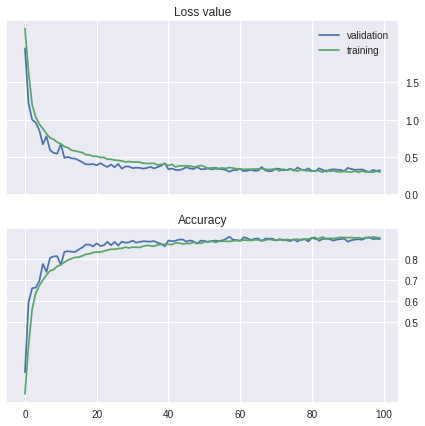

In [24]:
records     = pd.read_csv(folderpath+modelname +'.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'], label="validation")
plt.plot(records['loss'],label="training")
plt.yticks([0.00,0.50,1.00,1.50])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])

plt.subplot(212)
plt.plot(records['val_accuracy'],label="validation")
plt.plot(records['accuracy'],label="training")
plt.yticks([0.5,0.6,0.7,0.8])
plt.title('Accuracy',fontsize=12)
ax.legend()
plt.show()

## **19. Save the model plot**
---

In [25]:
plotpath  = folderpath+modelname+'_plot.png'
plot_model(model, 
           to_file=plotpath, 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')

print("Path to plot:", plotpath)

Path to plot: /content/gdrive/My Drive/iss/rtavs/colab/speechRV1_plot.png


## **20. Create a function to make prediction on a wavefile**
---

In [26]:
def commandPred(file):
    (smp,smpR)  = librosa.load(file,sr=16000)
    smp         = librosa.resample(smp,
                                   smpR, 
                                   resmpRate)
    smp         = smp.reshape(-1,inputLength,1)
    pred        = modelGo.predict(smp)
    pred        = np.argmax(pred,axis=1)
    
    return classes[pred[0]]


# ............................................................................
    
wfile       = '/content/gdrive/My Drive/iss/rtavs/data/voice01.wav'
pred        = commandPred(wfile)
print("The command predicted from '%s' is '%s'." % (wfile,pred) )

The command predicted from '/content/gdrive/My Drive/iss/rtavs/data/voice01.wav' is 'right'.
